In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
a=tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


print(sys.version)

Welcome to JupyROOT 6.22/02
3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [8]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()


path = '/storage/user/christiw/login-1/christiw/LLP/analyzer_backup/V1p17/MC_Fall18/v1/v110/normalized/'
path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v106/normalized/'
for m in [7,15,40,55]:
    for ctau in [100,1000,10000,100000]:
        fpath_bkg[str(m)+'_ctau'+str(ctau)] = path + 'ggH_HToSSTodddd_MH-125_MS-'+str(m)+'_ctau-'+str(ctau)+'_TuneCP5_13TeV-powheg-pythia8_59740pb_weighted.root'
        fpath_bkg[str(m)+'_ctau'+str(ctau)] = path + 'ggH_HToSSTodddd_MH-125_MS-'+str(m)+'_ctau-'+str(ctau)+'_TuneCP5_13TeV-powheg-pythia8_59740pb_weighted.root'
        fpath_bkg[str(m)+'_ctau'+str(ctau)] = path + 'ggH_HToSSTodddd_MH-125_MS-'+str(m)+'_ctau-'+str(ctau)+'_137000pb_weighted.root'


NEvents = {}

for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]


7_ctau100 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v106/normalized/ggH_HToSSTodddd_MH-125_MS-7_ctau-100_137000pb_weighted.root
7_ctau1000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v106/normalized/ggH_HToSSTodddd_MH-125_MS-7_ctau-1000_137000pb_weighted.root
7_ctau10000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v106/normalized/ggH_HToSSTodddd_MH-125_MS-7_ctau-10000_137000pb_weighted.root
7_ctau100000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v106/normalized/ggH_HToSSTodddd_MH-125_MS-7_ctau-100000_137000pb_weighted.root
15_ctau100 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v106/normalized/ggH_HToSSTodddd_MH-125_MS-15_ctau-100_137000pb_weighted.root
15_ctau1000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/

In [50]:
gLLP_decay_vertex = {}
gLLP_beta = {}
ctau = {}
genVertex = {}
gamma = {}
weight = {}
gLLP_csc = {}
sel_ev = {}
new_ctau = 10000 #cm
gLLP_decay_vertex_z = {}
gLLP_decay_vertex_r = {}
cluster_index = '3'
weight2 = {}
weight_sel={}
lumi = 1
weight_accep ={}
ctau_accep = {}
ctau_csc = {}
ctau_other = {}
ctau_sel = {}
decay_z_csc = {}
decay_r_csc = {}
decay_z_other = {}
decay_r_other = {}
nCsc = {}
dPhi = {}
for k,T in tree_bkg.items():
    T = tree_bkg[k]
#     ct = int(int(k[4:])/10)


    gLLP_decay_vertex[k] = np.sqrt(T.array('gLLP_decay_vertex_x')**2+T.array('gLLP_decay_vertex_y')**2+T.array('gLLP_decay_vertex_z')**2)
    gLLP_decay_vertex_z[k] = T.array('gLLP_decay_vertex_z')
    gLLP_decay_vertex_r[k] = T.array('gLLP_decay_vertex_r')



    gLLP_beta[k] = T.array('gLLP_beta')
    gamma[k] = 1.0/np.sqrt(1-gLLP_beta[k]**2)
    ctau[k] = ((gLLP_decay_vertex[k])/(gLLP_beta[k]*gamma[k]))


    weight[k] = T.array('weight')
    weight[k] = weight[k] * T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('metSF')
    
    
    sel_rechitcluster = np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0
    me1112_veto = 0
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < 10)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < 20)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))


########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > 50, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############

    sel_ev[k] = T.array('METTrigger')
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') > 200)
    sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() == 1)
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
#     sel_ev[k] = np.logical_and(sel_ev[k],np.sum(T.array('gLLP_csc'),axis=1)>=1)



    cond2 = np.logical_and(np.abs(T.array('cscRechitCluster' + cluster_index + 'AvgStation10'))==2, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 1.6)
    cond3 = np.logical_and(np.abs(T.array('cscRechitCluster' + cluster_index + 'AvgStation10'))==3, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 1.6)
    cond4 = np.logical_and(np.abs(T.array('cscRechitCluster' + cluster_index + 'AvgStation10'))==4, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 1.8)
    cond1 = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'NStation10')==1, np.logical_or(np.logical_or(np.abs(T.array('cscRechitCluster' + cluster_index + 'AvgStation10'))==1, cond2), np.logical_or(cond3, cond4)))
    cond2 = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'NStation10') > 1, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 1.9)
    cut_based = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        
    print(k, len(cut_based))
    
    weight_sel[k] = weight[k][sel_ev[k]][cut_based]
    ctau_sel[k] = ((gLLP_decay_vertex[k])/(gLLP_beta[k]*gamma[k]))[sel_ev[k]][cut_based]


    nCsc[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]][cut_based]
    dPhi[k] =  T.array('cscRechitCluster' + cluster_index + 'Met_dPhi')[sel_rechitcluster][sel_ev[k]][cut_based]


#     weight_accep[k] = weight[k][np.sum(T.array('gLLP_csc'),axis = 1) >= 1]
#     ctau_accep[k] = ctau[k][np.sum(T.array('gLLP_csc'),axis = 1) >= 1]
#     csc_temp = T.array('gLLP_csc')[np.sum(T.array('gLLP_csc'),axis = 1) >= 1]
#     accep=np.sum(T.array('gLLP_csc'),axis = 1) >= 1
    
    csc_temp = T.array('gLLP_csc')[sel_ev[k]][cut_based]
    index = np.array(1-csc_temp[:,0]==1,dtype=int)
    ctau_csc[k]=np.take_along_axis(ctau_sel[k], index[:,None],axis=1)
    ctau_other[k]=np.take_along_axis(ctau_sel[k], np.abs(1-index)[:,None],axis=1)
    decay_z_csc[k]=np.take_along_axis(gLLP_decay_vertex_z[k][sel_ev[k]][cut_based], index[:,None],axis=1)
    decay_r_csc[k]=np.take_along_axis(gLLP_decay_vertex_r[k][sel_ev[k]][cut_based], index[:,None],axis=1)
    decay_z_other[k]=np.take_along_axis(gLLP_decay_vertex_z[k][sel_ev[k]][cut_based], np.abs(1-index)[:,None],axis=1)
    decay_r_other[k]=np.take_along_axis(gLLP_decay_vertex_r[k][sel_ev[k]][cut_based], np.abs(1-index)[:,None],axis=1)

# #     print(k, np.sum(weight[k]), np.sum(weight[k][sel_ev[k]]),np.sum(weight[k][sel_ev[k]]**2)**0.5, np.sum(weight2[k]), np.sum(weight2[k][sel_ev[k]]))

7_ctau100 1958
7_ctau1000 2781
7_ctau10000 527
7_ctau100000 59
15_ctau100 861
15_ctau1000 3428
15_ctau10000 1158
15_ctau100000 159
40_ctau100 38
40_ctau1000 2304
40_ctau10000 2262
40_ctau100000 329
55_ctau100 1
55_ctau1000 990
55_ctau10000 2635
55_ctau100000 421


In [27]:
for k,v in weight_sel.items():
#     print(k,np.sum(weight_sel[k]),np.sum(weight_sel[k]**2)**0.5,np.sum(weight_sel[k]*reweighting(ctau_sel[k][:,0],ctau_sel[k][:,1])))
    print(k,len(weight_sel[k]),np.sum(reweighting(ctau_sel[k][:,0],ctau_sel[k][:,1])),np.sum(weight_calc(np.sum(ctau_sel[k],axis=1),10000,1000)))



7_ctau10000 195 22.314645198779406 11.315498024475822
7_ctau100000 26 4.637969777006665 1.0048873204493306e+21
15_ctau10000 421 91.63890004131048 27.9071173382303
15_ctau100000 59 21.692695126847404 1.435355075176408e+16
40_ctau10000 897 257.0119588183123 67.93755900964092
40_ctau100000 126 64.02634470267465 6.066254349987863e+22
55_ctau10000 961 260.6456952826527 72.61481244969103
55_ctau100000 144 75.1276573443963 2.905002150008677e+22


In [10]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    source = np.exp(-1.0*llp_ct/old_ctau)/old_ctau**2
    weight = 1.0/new_ctau**2 * np.exp(-1.0*llp_ct/new_ctau)/source
    return weight

# plot ctau

ctau10000 129796.67033600807
ctau100000 13129.610009789467
ctau100000weight 15669.35391853605
ctau10000 129796.67033600807
ctau100000 13129.610009789467
ctau100000weight 15669.35391853605


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: ctau100000weight (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ctau100000weightweight (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ctau100000weight (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ctau100000weight (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ctau100000weightweight (Potential memory leak).


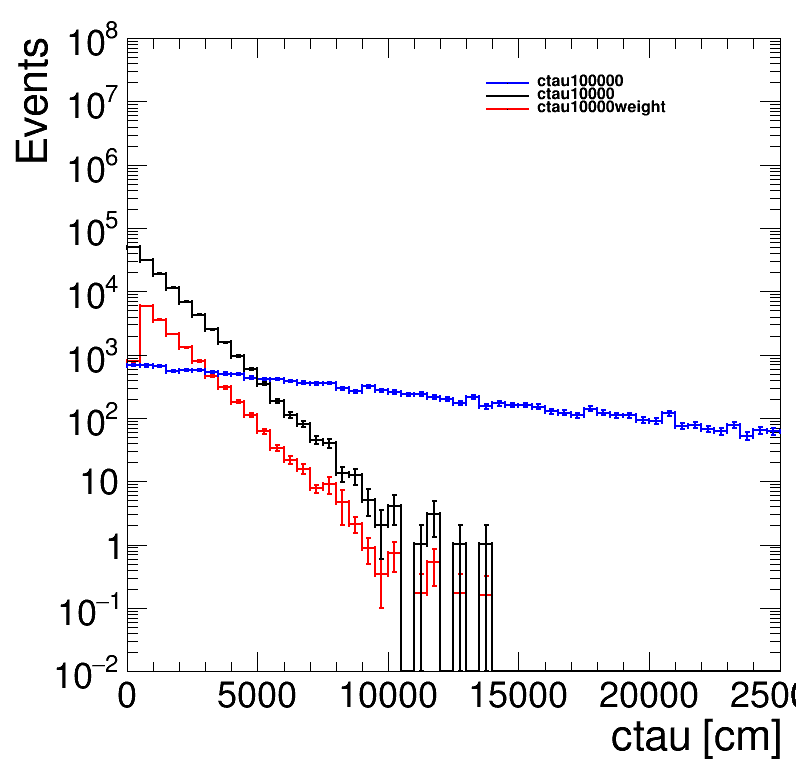

In [83]:
import ROOT as rt
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.60,0.850,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}
rt.gStyle.SetOptFit(1011)
bins = [50,0,25000]
# h['ctau10000'] = create_TH1D( np.sum(ctau['ctau10000'],axis = 1), axis_title=['ctau [cm]', 'Events'], name=k, binning=bins, weights=tree_bkg['ctau10000'].array('weight')*lumi)
# h['ctau100000'] = create_TH1D( np.sum(ctau['ctau100000'],axis = 1), axis_title=['ctau [cm]', 'Events'], name=k, binning=bins,weights=tree_bkg['ctau100000'].array('weight')*lumi)
# h['ctau100000weight'] = create_TH1D( np.sum(ctau['ctau10000'],axis = 1), axis_title=['ctau [cm]', 'Events'], name=k+'weight', binning=bins,\
#                                    weights = weight['ctau10000'])

# acceptance cut


h['ctau10000'] = create_TH1D( np.sum(ctau_accep['ctau10000'],axis=1), axis_title=['ctau [cm]', 'Events'], name=k, binning=bins, weights=tree_bkg['ctau10000'].array('weight')[np.sum(tree_bkg['ctau10000'].array('gLLP_csc'),axis = 1) >= 1])
h['ctau100000'] = create_TH1D( np.sum(ctau_accep['ctau100000'],axis=1), axis_title=['ctau [cm]', 'Events'], name=k, binning=bins,weights=tree_bkg['ctau100000'].array('weight')[np.sum(tree_bkg['ctau100000'].array('gLLP_csc'),axis = 1) >= 1])
h['ctau100000weight'] = create_TH1D( np.sum(ctau_accep['ctau10000'],axis=1), axis_title=['ctau [cm]', 'Events'], name=k+'weight', binning=bins,\
                                   weights = weight_accep['ctau10000'])

h['ctau10000'] = create_TH1D( ctau_other['ctau10000'][:,0], axis_title=['ctau [cm]', 'Events'], name=k, binning=bins, weights=tree_bkg['ctau10000'].array('weight')[np.sum(tree_bkg['ctau10000'].array('gLLP_csc'),axis = 1) >= 1])
h['ctau100000'] = create_TH1D( ctau_other['ctau100000'][:,0], axis_title=['ctau [cm]', 'Events'], name=k, binning=bins,weights=tree_bkg['ctau100000'].array('weight')[np.sum(tree_bkg['ctau100000'].array('gLLP_csc'),axis = 1) >= 1])
h['ctau100000weight'] = create_TH1D( ctau_other['ctau10000'][:,0], axis_title=['ctau [cm]', 'Events'], name=k+'weight', binning=bins,\
                                   weights =  tree_bkg['ctau10000'].array('weight')[np.sum(tree_bkg['ctau10000'].array('gLLP_csc'),axis = 1) >= 1]*reweighting(ctau_accep['ctau10000'][:,0], ctau_accep['ctau10000'][:,1]))
# bins = [50,0,2500000]
# h['ctau10000'] = create_TH1D( decay_z_other['ctau10000'][:,0], axis_title=['decay Z [cm]', 'Events'], name=k, binning=bins, weights=tree_bkg['ctau10000'].array('weight')[np.sum(tree_bkg['ctau10000'].array('gLLP_csc'),axis = 1) >= 1])
# h['ctau100000'] = create_TH1D( decay_z_other['ctau100000'][:,0], axis_title=['decay Z [cm]', 'Events'], name=k, binning=bins,weights=tree_bkg['ctau100000'].array('weight')[np.sum(tree_bkg['ctau100000'].array('gLLP_csc'),axis = 1) >= 1])
# h['ctau100000weight'] = create_TH1D( decay_z_other['ctau10000'][:,0], axis_title=['decay Z [cm]', 'Events'], name=k+'weight', binning=bins,\
#                                    weights = tree_bkg['ctau10000'].array('weight')[np.sum(tree_bkg['ctau10000'].array('gLLP_csc'),axis = 1) >= 1]*\
#                                     reweighting(ctau_accep['ctau10000'][:,0], ctau_accep['ctau10000'][:,1]))




for k,v in h.items():
    print(k, v.Integral())

# for i in range(h['ctau10000'].GetXaxis().GetNbins()):
#     if h['ctau10000'].GetBinContent(i+1)>0 and h['ctau10000'].GetBinError(i+1)/h['ctau10000'].GetBinContent(i+1)>0.1:
#         print(0,i, h['ctau10000'].GetBinError(i+1),h['ctau10000'].GetBinContent(i+1))
#     if h['ctau100000'].GetBinError(i+1)/h['ctau100000'].GetBinContent(i+1)>0.1:
#         print(i)
# # for k,T in tree_bkg.items():
# #     gLLP_csc = np.sum(T.array('gLLP_csc'),axis = 1)>=0
# #     h[k] = create_TH1D( np.sum(T.array('gLLP_ctau'),axis = 1)[gLLP_csc], axis_title=['ctau [cm]', 'Events'], name=k, binning=bins, \
# #                        weights=T.array('weight')[gLLP_csc]*50000)
# #     h[k] = create_TH1D( T.array('gLLP_ctau')[:,0][gLLP_csc], axis_title=['ctau [cm]', 'Events'], name=k, binning=bins, \
# #                        weights=T.array('weight')[gLLP_csc]*50000)
# # # h['ctau10000'].SetLineColor(2)
# # # c = make_ratio_plot([h['ctau10000'],h['ctau100000']], fit = False, logy=True, in_tags =['10m','100m'] , ratio_bounds = [0.0005,150],draw_opt = ['E2','E1']) 

# h['ctau10000'] = create_TH1D( np.sum(ctau['ctau10000'], axis = 1)[sel_ev['ctau10000']], axis_title=['ctau [cm]', 'Events'], name=k, binning=bins,\
#                              weights=tree_bkg['ctau10000'].array('weight')[sel_ev['ctau10000']]*lumi)
# h['ctau100000'] = create_TH1D( np.sum(ctau['ctau100000'], axis = 1)[sel_ev['ctau100000']], axis_title=['ctau [cm]', 'Events'], name=k, binning=bins,\
#                               weights=tree_bkg['ctau100000'].array('weight')[sel_ev['ctau100000']]*lumi)
# k = 'ctau100000'
# h['ctau100000weight'] = create_TH1D( np.sum(ctau[k], axis = 1)[sel_ev[k]], axis_title=['ctau [cm]', 'Events'], name=k+'weight', binning=bins,\
#                                    weights = weight[k][sel_ev[k]])
# # bins = [50,0,1000]
# # h['ctau10000'] = create_TH1D( gLLP_decay_vertex_r['ctau10000'], axis_title=['LLP decay vertex R [cm]', 'Events'], name=k, binning=bins, weights=tree_bkg['ctau10000'].array('weight')[sel_ev['ctau10000']]*lumi)
# # h['ctau100000'] = create_TH1D( gLLP_decay_vertex_r['ctau100000'], axis_title=['LLP decay vertex R [cm]', 'Events'], name=k, binning=bins,weights=tree_bkg['ctau100000'].array('weight')[sel_ev['ctau100000']]*lumi)
# # h['ctau100000weight'] = create_TH1D( gLLP_decay_vertex_r['ctau100000'], axis_title=['LLP decay vertex R [cm]', 'Events'], name=k+'weight', binning=bins,\
# #                                    weights = weight['ctau100000'])


# # h['ctau10000'].SetMaximum(10000000)
# # h[k].SetMinimum(0.1)


h['ctau10000'].SetLineColor(std_color_list[0])
h['ctau100000weight'].SetLineColor(std_color_list[1])
h['ctau100000'].SetLineColor(std_color_list[2])
h['ctau100000weight'].SetMinimum(0.01)
h['ctau100000weight'].SetMaximum(10E7)




leg.AddEntry(h['ctau100000'], 'ctau100000')
leg.AddEntry(h['ctau10000'], 'ctau10000')
leg.AddEntry(h['ctau100000weight'], 'ctau10000weight')



h['ctau100000weight'].Draw('same hist E1')
h['ctau100000'].Draw('same hist E1')
h['ctau10000'].Draw('same hist E1')

for k,v in h.items():print(k,v.Integral())


leg.Draw()
c.SetLogy()


c.Draw()

    
    


# c.Draw()
# print(time.time()-start_t)

In [81]:
reweighting(ctau_accep['ctau10000'][:,0], ctau_accep['ctau10000'][:,1])

array([0.16605411, 0.01138187, 0.16579811, ..., 0.01445223, 0.0163855 ,
       0.00729298])

# plot 2D weight histogram

In [11]:
import math

[0, 25, 50, 75, 100, 200, 300, 400, 500, 750, 1000, 0, 25, 50, 75, 100, 200, 300, 400, 500, 750, 1000, 11, 11]
1000.0
0.0017484696428384505 0.0017484696428384505
0.0017484696428384505 0.16054297923079272


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: 55_ctau100000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: 55_ctau100000 (Potential memory leak).


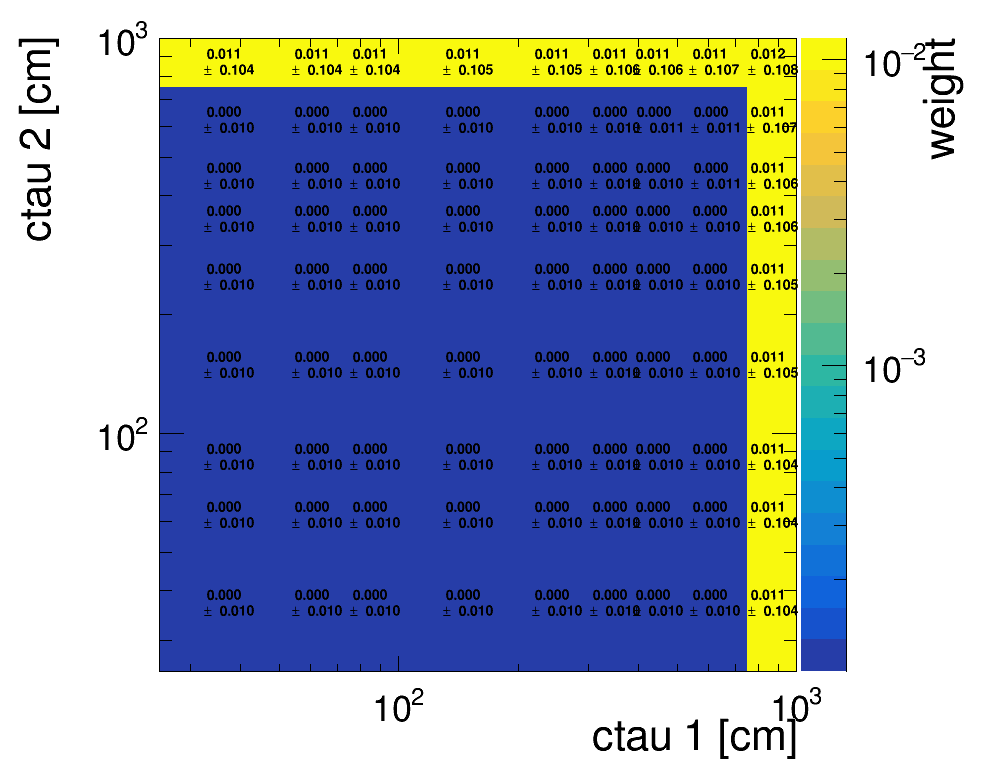

In [51]:
c = rt.TCanvas('c','c', 1000, 800)
rt.gStyle.SetPaintTextFormat("6.3f")

bins = [0,25,50,75,100,200,300,400,500,750,1000] #100 --> 1000
# bins = [0,10,20,30,50,75,100,200,300,400,500,600,700,800,900,1000] #10m-->100

# bins = [0,10,20,30,50,75,100,200,300,400,1000] #1m-->10m

# bins = [0,10,20,30,50,75,100]#0.1m




bins = bins *2
bins+=[int(len(bins)/2),int(len(bins)/2)]
print(bins)
# bins = [50,0,10000,50,0,10000]

target_tau, source_tau = 10000, 100 #m
target_tau *= 100
source_tau *= 100
overflow = np.random.exponential(target_tau, size=(1000,2))
overflow[overflow>999] = 999

h_target = create_TH2D( np.column_stack((overflow[:,0],overflow[:,1])), axis_title=['ctau 1 [cm]', 'ctau 2 [cm]', 'weight'], name=k, binning=bins)
print(h_target.Integral())
test = 0
for x in range(h_target.GetNbinsX()):
    for y in range(h_target.GetNbinsY()):
        x1,x2 = h_target.GetXaxis().GetBinLowEdge(x+1), h_target.GetXaxis().GetBinLowEdge(x+1)+h_target.GetXaxis().GetBinWidth(x+1)
        y1,y2 = h_target.GetYaxis().GetBinLowEdge(y+1), (h_target.GetYaxis().GetBinLowEdge(y+1)+h_target.GetYaxis().GetBinWidth(y+1))
        if x == h_target.GetNbinsX()-1:h_target.SetBinContent(x+1,y+1,(math.exp(-x1/target_tau))*(math.exp(-y1/target_tau)-math.exp(-y2/target_tau)))
        elif y == h_target.GetNbinsY()-1:h_target.SetBinContent(x+1,y+1,(math.exp(-x1/target_tau)-math.exp(-x2/target_tau))*(math.exp(-y1/target_tau)))
        else: h_target.SetBinContent(x+1,y+1,(math.exp(-x1/target_tau)-math.exp(-x2/target_tau))*(math.exp(-y1/target_tau)-math.exp(-y2/target_tau)))
#         print(x1,x2,y1,y2, x == h_target.GetNbinsX(), y == h_target.GetNbinsY(), (math.exp(-x1/target_tau)-math.exp(-x2/target_tau))*(math.exp(-y1/target_tau)), h_target.GetBinContent(x+1,y+1))

        test+=h_target.GetBinContent(x+1,y+1)
print(h_target.Integral(),test)
# h_target.Scale(1./h_target.Integral())
overflow = ctau[source].copy()
overflow = np.random.exponential(source_tau, size=(1000,2))
overflow[overflow>999] = 999

h_source = create_TH2D( np.column_stack((overflow[:,0],overflow[:,1])), axis_title=['ctau [cm]', 'ctau 2 [cm]', 'weight'], name=k, binning=bins)
# h_source.Scale(1./h_source.Integral())
for x in range(h_source.GetNbinsX()+1):
    for y in range(h_source.GetNbinsY()):
        x1,x2 = h_source.GetXaxis().GetBinLowEdge(x+1), h_source.GetXaxis().GetBinLowEdge(x+1)+h_source.GetXaxis().GetBinWidth(x+1)
        y1,y2 = h_source.GetYaxis().GetBinLowEdge(y+1), h_source.GetYaxis().GetBinLowEdge(y+1)+h_source.GetYaxis().GetBinWidth(y+1)
        if x == h_source.GetNbinsX()-1:h_source.SetBinContent(x+1,y+1,(math.exp(-x1/source_tau))*(math.exp(-y1/source_tau)-math.exp(-y2/source_tau)))
        elif y == h_source.GetNbinsY()-1:h_source.SetBinContent(x+1,y+1,(math.exp(-x1/source_tau)-math.exp(-x2/source_tau))*(math.exp(-y1/source_tau)))
        else: h_source.SetBinContent(x+1,y+1,(math.exp(-x1/source_tau)-math.exp(-x2/source_tau))*(math.exp(-y1/source_tau)-math.exp(-y2/source_tau)))
print(h_target.Integral(),h_source.Integral())

h_target.Divide(h_source)

h_target.Draw('colz textE')
c.SetRightMargin(0.2)
c.SetLogz()
c.SetLogx()
c.SetLogy()



c.Draw()


In [52]:
# save reweight TH2D
outputFileName = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/ctau_reweight.root'
outFile = rt.TFile(outputFileName, 'RECREATE')


outFile.WriteTObject(h_target, 'h_reweight', "WriteDelete");
outFile.Close();


In [53]:
root_dir = uproot.open(outputFileName) 
h_reweight = root_dir['h_reweight']
def reweighting(ctau1, ctau2):
    return h_reweight.values[np.argmax(h_reweight.edges[0]>ctau1[:,None],axis=1)-1, np.argmax(h_reweight.edges[1]>ctau2[:,None],axis=1)-1]


In [54]:
for k,v in weight_sel.items():
#     if not '1000' in k:continue
#     if '100000' in k:continue
#     print(k,np.sum(weight_sel[k]),np.sum(weight_sel[k]**2)**0.5,np.sum(weight_sel[k]*reweighting(ctau_sel[k][:,0],ctau_sel[k][:,1])))
    temp= weight_sel[k]*reweighting(ctau_sel[k][:,0],ctau_sel[k][:,1])
    print(k,np.sum(weight_sel[k]),np.sum(weight_sel[k]**2)**0.5,np.sum(temp), np.sum(temp**2)**0.5)





7_ctau100 1691.9546 43.270581943379845 0.16969556399197633 0.004339872111270455
7_ctau1000 2469.7861 52.66688968917046 0.2705960871659099 0.014899866046407527
7_ctau10000 450.1634 22.33513000245493 2.3066429788063383 0.16424069864159224
7_ctau100000 54.94762 7.7569371831213525 0.5900431660766267 0.08409419377887717
15_ctau100 693.1671 27.43465914606809 0.0695964498849311 0.0027547394970953
15_ctau1000 3128.6465 59.5802927090567 0.3192819387023298 0.006081505725465942
15_ctau10000 1011.98895 32.9609680537308 5.389964777722101 0.2499637884443997
15_ctau100000 128.16171 11.985425363439468 1.3424789964390742 0.12912696787165098
40_ctau100 20.90376 4.602186902206049 0.0021038987185119755 0.0004632109635871495
40_ctau1000 1918.9464 45.906457411035866 0.21610365773280074 0.014028908601927629
40_ctau10000 2019.9557 47.17616016475509 11.833323337172384 0.37804146796997184
40_ctau100000 299.1872 18.15313263228235 3.07425256053343 0.193481080737335
55_ctau100 0.8515388 0.8515387715524715 8.600104

24
[0, 25, 50, 75, 100, 200, 300, 400, 500, 750, 1000, 0, 25, 50, 75, 100, 200, 300, 400, 500, 750, 1000, 11, 11]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: 55_ctau100000 (Potential memory leak).


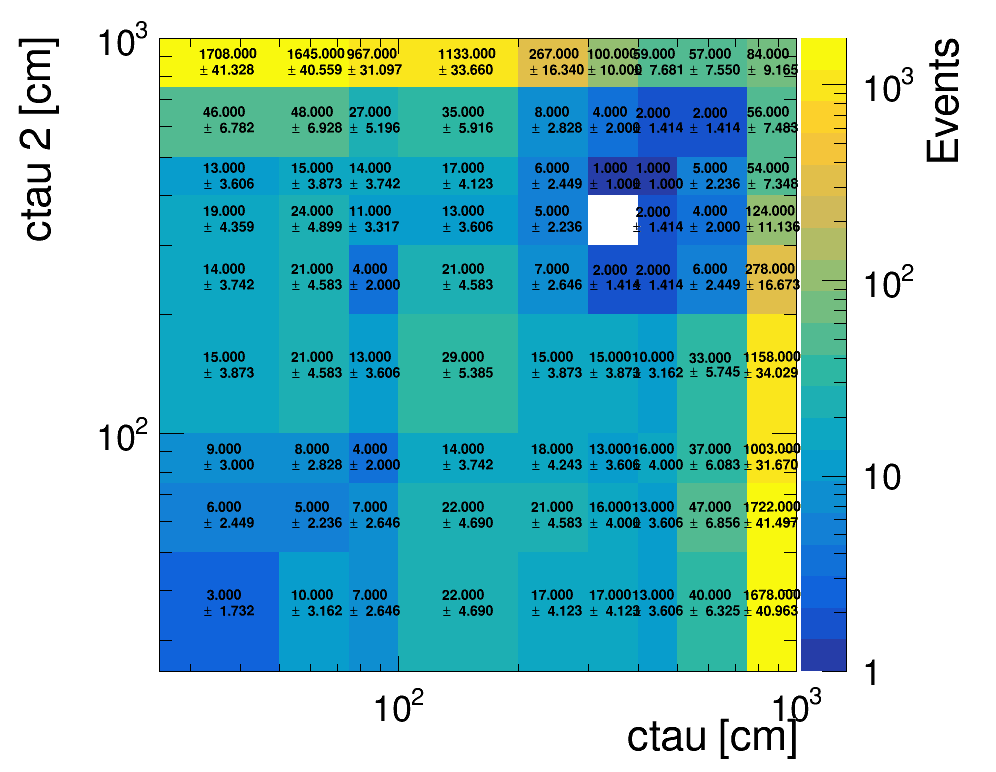

In [290]:
c = rt.TCanvas('c','c', 1000, 800)
rt.gStyle.SetPaintTextFormat("6.3f")

# target = 'ctau100000'
source = '7_ctau100000'
bins = [0,25,50,75,100,200,300,400,500,750,1000] #10m-->100


bins = bins *2
bins+=[int(len(bins)/2),int(len(bins)/2)]
print(len(bins))
print(bins)

# overflow = ctau[target].copy()
# overflow[overflow>999] = 999

# h_target = create_TH2D( np.column_stack((overflow[:,0],overflow[:,1])), axis_title=['ctau 1 [cm]', 'ctau 2 [cm]', 'Events'], name=k, binning=bins,\
#                        weights=tree_bkg[target].array('weight')[np.sum(tree_bkg[target].array('gLLP_csc'),axis = 1) >= 1])

overflow = ctau[source].copy()
overflow[overflow>999] = 999
T = tree_bkg[source]
overflow = overflow[np.sum(T.array('gLLP_csc'),axis = 1) >= 1]
h_source = create_TH2D( np.column_stack((overflow[:,0],overflow[:,1])), axis_title=['ctau [cm]', 'ctau 2 [cm]', 'Events'], name=k, binning=bins)
# h_target.Divide(h_source)

h_source.Draw('colz textE')
c.SetRightMargin(0.2)
c.SetLogz()
c.SetLogx()
c.SetLogy()
c.Draw()



1.2105593236513044
ctau10000 2992.9413943886757
ctau100000 420.76822316646576
ctau10000weight 3623.133110119147

****************************************
Minimizer is Minuit / Migrad
MinFCN                    = -1.33922e-12
Chi2                      =  5.71563e-18
NDf                       =            0
Edm                       =  1.27611e-16
NCalls                    =           33
Constant                  =      8.26702   +/-   0.0259477   
Slope                     =  -0.00217989   +/-   6.15274e-05 

0.0
original ctau is: 4587.378744431602 mm

****************************************
Minimizer is Minuit / Migrad
MinFCN                    = -1.17311e-12
Chi2                      =  5.77181e-18
NDf                       =            0
Edm                       =  2.00289e-16
NCalls                    =           24
Constant                  =      8.26702   +/-   0.0364154   
Slope                     =  -0.00217989   +/-   8.39157e-05 

0.0
new ctau is: 4587.378746157872 mm


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: ctau100000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ctau100000weight (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ctau100000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ctau100000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ctau100000weight (Potential memory leak).


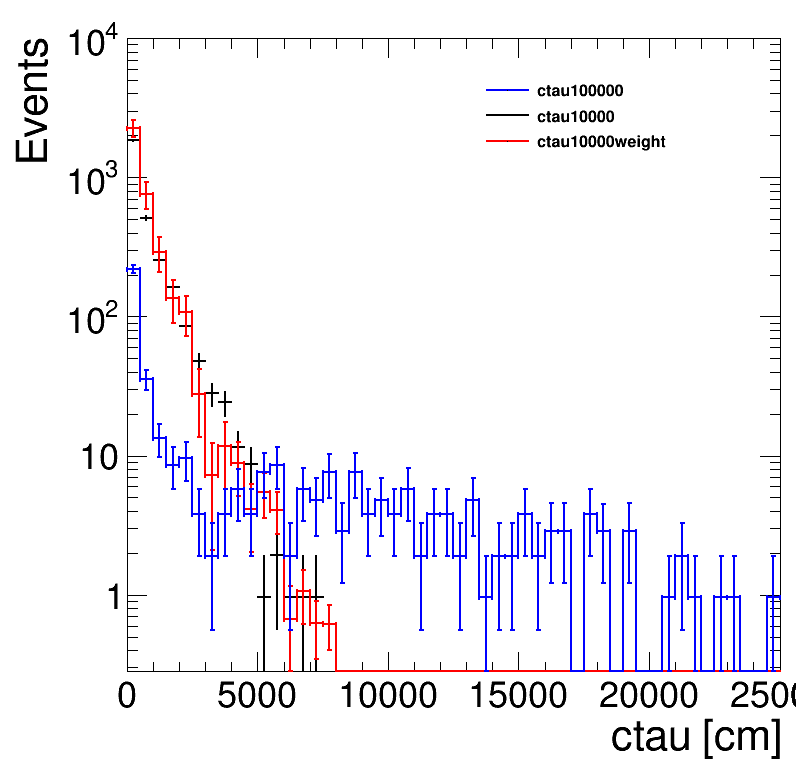

In [15]:

c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.60,0.80,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}
rt.gStyle.SetOptFit(1011)

# bins = [50,0,1000]
# print(ctau[k].shape)
# h[k] = create_TH1D( ctau[k].flatten(), axis_title=['c#tau [cm]', 'Events'], name=k, binning=bins)
# w = np.transpose(np.vstack((weight[k],weight[k])))
# h[k+'weight'] = create_TH1D( ctau[k].flatten(), axis_title=['c#tau [cm]', 'Events'], name=k+'weight', binning=bins,weights = w.flatten())

# bins = [50,0,5000]
# h[k] = create_TH1D( gLLP_decay_vertex[k].flatten(), axis_title=['decay vertex [cm]', 'Events'], name=k, binning=bins)
# w = np.transpose(np.vstack((weight[k],weight[k])))
# h[k+'weight'] = create_TH1D( gLLP_decay_vertex[k].flatten(), axis_title=['decay vertex [cm]', 'Events'], name=k+'weight', binning=bins,weights = w.flatten())

bins = [50,0,25000]

h['ctau10000'] = create_TH1D( ctau['ctau10000'][:,0], axis_title=['ctau [cm]', 'Events'], name=k, binning=bins, weights=tree_bkg['ctau10000'].array('weight')*lumi)
h['ctau100000'] = create_TH1D( ctau['ctau100000'][:,0], axis_title=['ctau [cm]', 'Events'], name=k, binning=bins,weights=tree_bkg['ctau100000'].array('weight')*lumi)
k = 'ctau100000'

h['ctau10000weight'] = create_TH1D( ctau[k][:,0], axis_title=['decay vertex [cm]', 'Events'], name=k+'weight', binning=bins,\
                                   weights = weight[k])
# h['ctau10000'] = create_TH1D( ctau['ctau10000'][:,0][gLLP_csc['ctau10000'][:,0]], axis_title=['ctau [cm]', 'Events'], name=k, binning=bins,\
#                              weights=tree_bkg['ctau10000'].array('weight')[gLLP_csc['ctau10000'][:,0]]*lumi)
# h['ctau100000'] = create_TH1D( ctau['ctau100000'][:,0][gLLP_csc['ctau100000'][:,0]], axis_title=['ctau [cm]', 'Events'], name=k, binning=bins,\
#                               weights=tree_bkg['ctau100000'].array('weight')[gLLP_csc['ctau100000'][:,0]]*lumi)
# k = 'ctau100000'

# h['ctau10000weight'] = create_TH1D( ctau[k][:,0][gLLP_csc[k][:,0]], axis_title=['decay vertex [cm]', 'Events'], name=k+'weight', binning=bins,\
#                                    weights = weight[k][gLLP_csc[k][:,0]])


h['ctau10000'] = create_TH1D( ctau['ctau10000'][:,0][sel_ev['ctau10000']], axis_title=['ctau [cm]', 'Events'], name=k, binning=bins,\
                             weights=tree_bkg['ctau10000'].array('weight')[sel_ev['ctau10000']]*lumi)
h['ctau100000'] = create_TH1D( ctau['ctau100000'][:,0][sel_ev['ctau100000']], axis_title=['ctau [cm]', 'Events'], name=k, binning=bins,\
                              weights=tree_bkg['ctau100000'].array('weight')[sel_ev['ctau100000']]*lumi)
k = 'ctau100000'

h['ctau10000weight'] = create_TH1D( ctau[k][:,0][sel_ev[k]], axis_title=['decay vertex [cm]', 'Events'], name=k+'weight', binning=bins,\
                                   weights = weight[k][sel_ev[k]])




print(h['ctau10000weight'].Integral()/h['ctau10000'].Integral() )

h['ctau10000'].SetMaximum(10000)
h[k].SetMinimum(0.1)



for k, v in h.items():
    print(k,v.Integral())

h['ctau10000'].SetLineColor(std_color_list[0])
h['ctau10000weight'].SetLineColor(std_color_list[1])
h['ctau100000'].SetLineColor(std_color_list[2])


leg.AddEntry(h['ctau100000'], 'ctau100000')
leg.AddEntry(h['ctau10000'], 'ctau10000')
leg.AddEntry(h['ctau10000weight'], 'ctau10000weight')




# #     h[k].SetMinimum(1)
# h[k].GetXaxis().SetLabelSize(0.04)
r = h[k].Fit('expo', 'LRSQ+0', '', 0,1000)
print(r.Get())
print(r.Prob())
# h[k].GetFunction("expo").SetLineColor(std_color_list[0])
# h[k].GetFunction("expo").SetLineStyle(2)
# h[k].GetFunction("expo").SetLineWidth(2)
print('original ctau is: '+str(-1.0/r.Parameter(1)*10)+' mm')
# h[k].GetFunction("expo").Delete()

r = h['ctau10000weight'].Fit('expo', 'LRSQ+0', 'a', 0,1000)
print(r.Get())
print(r.Prob())

print('new ctau is: '+str(-1.0/r.Parameter(1)*10)+' mm')
h['ctau10000'].Draw()

h['ctau10000weight'].Draw('same hist E1')
h['ctau100000'].Draw('same hist E1')



leg.Draw('same')
c.SetLogy()


c.Draw()

    
    


# c.Draw()
# print(time.time()-start_t)

In [156]:
k = 'ctau100000'
a = weight[k][sel_ev[k]][ctau[k][:,0][sel_ev[k]]<1000]
print(a[a>1])

[42.73897528  2.29171812 38.70680442 35.81001811 39.50640705 36.12977989
  3.37273467 37.79862122  3.91415636 32.79364033 19.74859956 49.75855914
 43.07316594  1.67334556 58.17238108 14.27678191 33.76875255 18.62881064
 24.9684636  56.74106546 40.22860912  1.822286   35.72260129  8.94478518
  9.30171281  6.95492971 64.0616661  26.78254609 25.76377892 38.1347834
 22.91274854 29.03366858 33.01166884 53.7333892 ]


# compare other variables

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: bbbb (Potential memory leak).


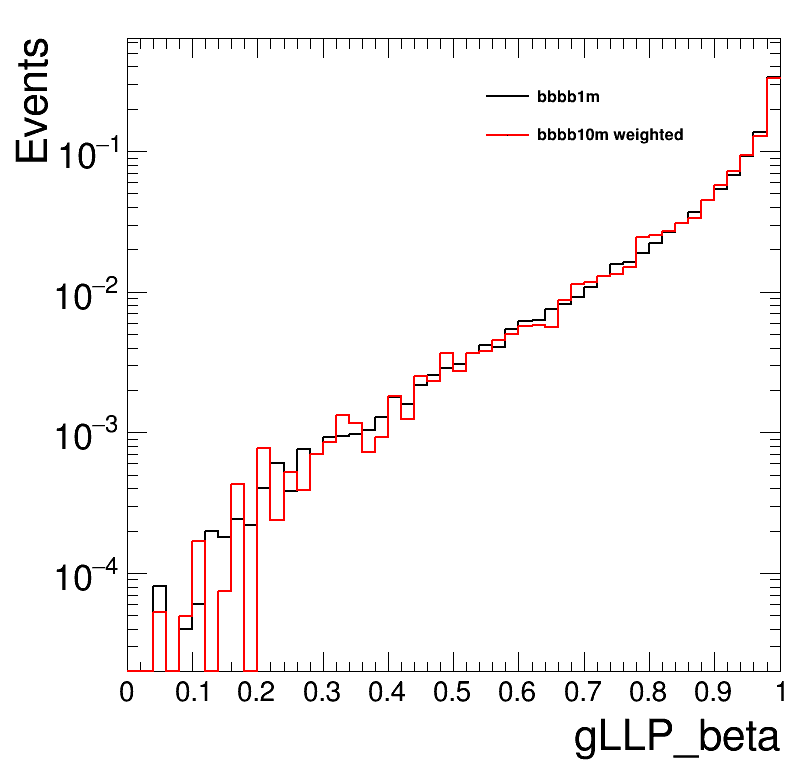

In [100]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'data_intime'

# h[k] = create_TH2D(np.column_stack((angle[k][cond],jetPt[k][cond][:,0])), axis_title = ['\Delta\phi (jet,met)','jet p_{T}[GeV]','Events'], binning=[80,-3.14,3.14,100,0,2000])
h[k] = create_TH2D(np.column_stack(( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], dphiMet_cluster[k])),
                   axis_title = ['N_{rechits}','\Delta\phi (cluster,met)','Events'], binning=[50,0,600,50,0,3.14])


h[k].GetXaxis().SetLabelSize(0.04)




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)